# Normal Mode Analysis with ProDy
## ANM (Anisotropic Network Model)


In [5]:
import prody as pr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Enable ProDy output
pr.confProDy(verbosity='info')

# Parameters
pdb_path = "/Users/ymeng/Desktop/ThomaLab/R_projects/MaSIF-Neosurf_v4.0/R/cache/domainome/AF-P04049-F1-model_v6.pdb"


@> ProDy is configured: verbosity='info'


In [7]:
import prody as pr
import numpy as np

# --- Load and select atoms (could be CA or all heavy atoms) ---
atoms = pr.parsePDB(pdb_path)
N = atoms.numAtoms()


In [8]:
# --- Build ANM and modes ---
anm = pr.ANM('all-atom ANM')
anm.buildHessian(atoms, cutoff=10.0)            # tighter cutoff for all-atom
anm.calcModes(n_modes=None)                     # all non-trivial modes
modes = anm[:50]                                # keep k lowest non-trivial modes (tune k)

In [ ]:
# Analyze all-atom ANM by creating a covariance matrix
# --- Covariance from modes ---
# ProDy provides covariance directly from modes
Sigma = pr.calcCovariance(modes)                # shape (3N, 3N)

# --- Helper: extract 3x3 block (i,j) ---
def block(S, i, j):
    si, sj = slice(3*i, 3*i+3), slice(3*j, 3*j+3)
    return S[si, sj]

# --- Precompute per-atom self blocks and their traces ---
Sigma_ii_trace = np.empty(N)
for i in range(N):
    Sigma_ii_trace[i] = np.trace(block(Sigma, i, i))

# --- Build MSRD and/or Corr matrices (N x N) ---
MSRD = np.empty((N, N), dtype=np.float32)
Corr = np.empty((N, N), dtype=np.float32)

for i in range(N):
    ti = Sigma_ii_trace[i]
    for j in range(N):
        tj = Sigma_ii_trace[j]
        tij = np.trace(block(Sigma, i, j))
        # Relative RMS displacement:
        msrd_ij = max(ti + tj - 2.0*tij, 0.0)
        MSRD[i, j] = np.sqrt(msrd_ij)
        # Cross-correlation (clip for numerical safety):
        denom = np.sqrt(max(ti, 1e-12) * max(tj, 1e-12))
        Corr[i, j] = float(np.clip(tij / denom, -1.0, 1.0))



In [31]:
Sigma

array([[ 1.67491345e-01, -1.47442286e-01,  1.18257657e-01, ...,
         3.09218924e-01,  3.06465875e-01, -1.42620675e-01],
       [-1.47442286e-01,  2.89916221e-01, -1.98855795e-01, ...,
        -2.49669308e-01, -2.74971938e-01,  5.67004383e-02],
       [ 1.18257657e-01, -1.98855795e-01,  7.13695197e-01, ...,
         9.70027897e-01,  1.09169045e+00, -5.55022289e-01],
       ...,
       [ 3.09218924e-01, -2.49669308e-01,  9.70027897e-01, ...,
         7.37262851e+01,  1.70640221e+01, -1.14615863e+01],
       [ 3.06465875e-01, -2.74971938e-01,  1.09169045e+00, ...,
         1.70640221e+01,  2.77177430e+01, -1.60657177e+01],
       [-1.42620675e-01,  5.67004383e-02, -5.55022289e-01, ...,
        -1.14615863e+01, -1.60657177e+01,  1.51537353e+01]],
      shape=(15390, 15390))

In [28]:
import numpy as np

def directional_coupling_along_bond(coords, Sigma):
    """
    coords : (N,3) float array of atomic coordinates (Å)
    Sigma  : (3N,3N) covariance of displacements (same units^2)
             Typically built from ENM/ANM modes (non-rigid modes only).

    Returns
    -------
    radial_msrd : (N,N) float
        RMS of (delta_r_i - delta_r_j) projected on the unit bond vector r_ij/|r_ij|.
        Distance-like, >= 0.
    radial_corr : (N,N) float in [-1,1]
        Signed correlation of motions along the bond direction (together vs. opposite).
    """
    N = coords.shape[0]
    assert Sigma.shape == (3*N, 3*N)

    def blk(i, j):
        si, sj = slice(3*i, 3*i+3), slice(3*j, 3*j+3)
        return Sigma[si, sj]

    # Precompute self/cross 3x3 blocks as needed
    Sii = [blk(i, i) for i in range(N)]

    radial_msrd = np.zeros((N, N), dtype=float)
    radial_corr = np.zeros((N, N), dtype=float)

    eps = 1e-12
    for i in range(N):
        for j in range(N):
            if i == j:
                # zero relative motion by definition; correlation undefined -> set 1.0
                radial_msrd[i, j] = 0.0
                radial_corr[i, j] = 1.0
                continue

            rij = coords[j] - coords[i]
            norm = np.linalg.norm(rij)
            if norm < 1e-9:
                # overlapping coordinates: skip or set NaN
                radial_msrd[i, j] = 0.0
                radial_corr[i, j] = 0.0
                continue
            e = rij / norm  # unit bond direction i->j

            Sij = blk(i, j)
            Sji = Sij.T  # should be transpose for symmetric Sigma

            # Variance of ( (dr_i - dr_j) · e ) = eᵀ (Sii + Sjj - Sij - Sji) e
            S_rel = Sii[i] + Sii[j] - Sij - Sji
            var_rel = float(e @ S_rel @ e)
            var_rel = max(var_rel, 0.0)      # numeric safety
            radial_msrd[i, j] = np.sqrt(var_rel)

            # Signed correlation along e: (eᵀ Sij e) / sqrt( (eᵀ Sii e)(eᵀ Sjj e) )
            num = float(e @ Sij @ e)
            den = np.sqrt(max(float(e @ Sii[i] @ e), eps) * max(float(e @ Sii[j] @ e), eps))
            radial_corr[i, j] = np.clip(num / den, -1.0, 1.0)

    return radial_msrd, radial_corr

# Example usage:
# coords: shape (N,3); Sigma: shape (3N,3N)
coords = atoms.getCoords()
radial_msrd, radial_corr = directional_coupling_along_bond(coords, Sigma)

In [10]:
# --- Per-atom vectors ---
per_atom_vector_MSRD = MSRD                     # row i is vector v_i (distance-like)
per_atom_vector_Corr = Corr                     # row i is vector v_i (similarity-like)

# (Optional) Sparsify/compress here before saving to disk
np.save("per_atom_MSRD.npy", per_atom_vector_MSRD)
np.save("per_atom_Corr.npy", per_atom_vector_Corr)

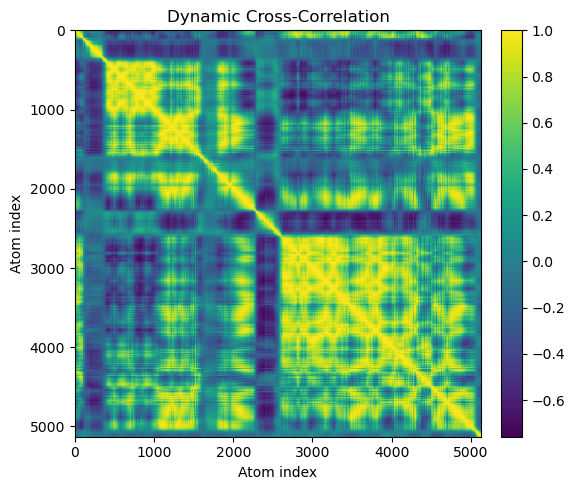

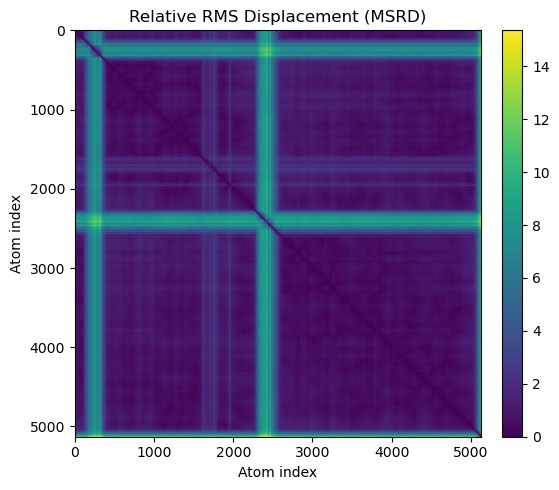

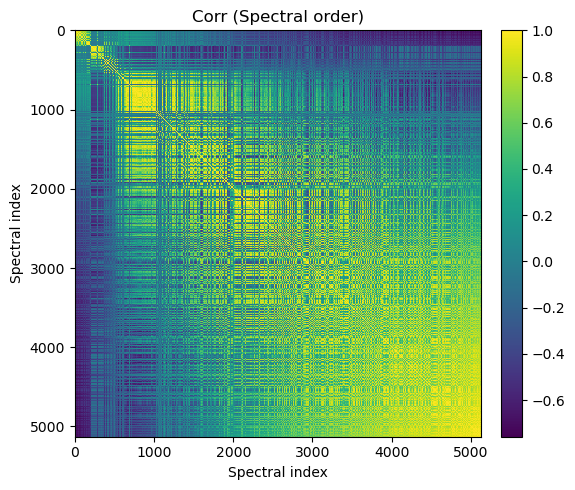

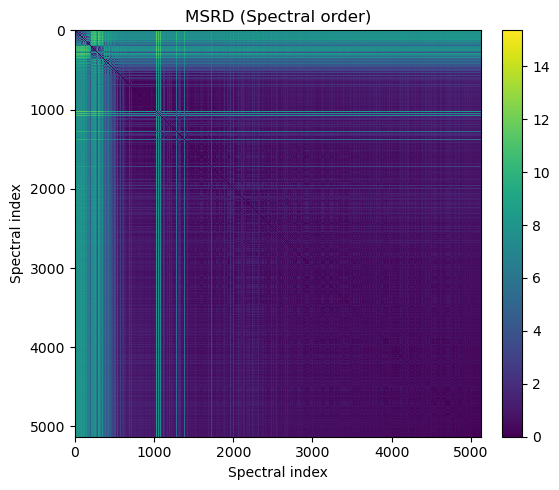

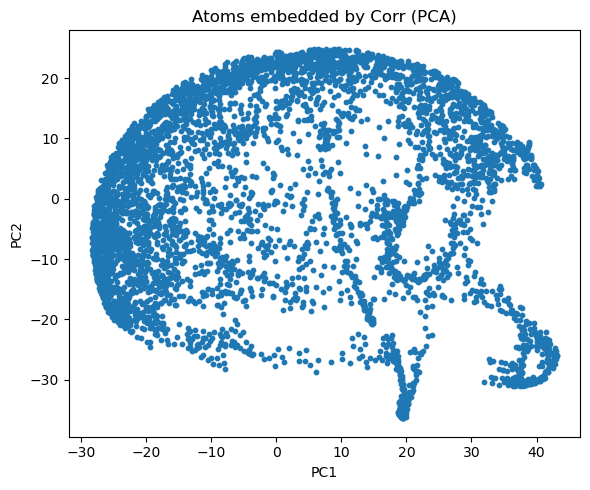

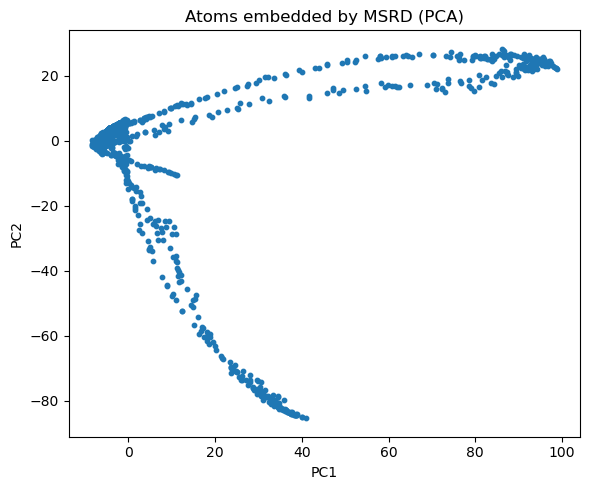

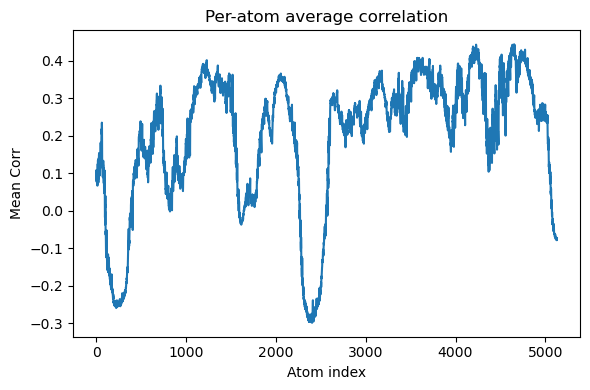

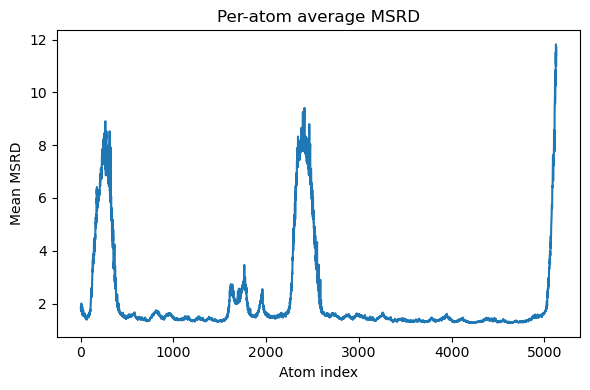

In [14]:
# --- hygiene ---
MSRD = 0.5*(MSRD+MSRD.T); MSRD = np.maximum(MSRD,0)
Corr = 0.5*(Corr+Corr.T); Corr = np.clip(Corr,-1,1)
N = MSRD.shape[0]

# --- spectral order (Fiedler) on Corr ---
A = (Corr+1)/2
d = A.sum(1); d = np.where(d<1e-12,1e-12,d)
L = np.diag(d)-A
w,V = np.linalg.eigh(L)
order = np.argsort(V[:,1]) if N>=2 else np.arange(N)
MSRD_ord = MSRD[np.ix_(order,order)]
Corr_ord = Corr[np.ix_(order,order)]

# --- simple PCA via SVD ---
def pca2(X):
    Xc = X - X.mean(0,keepdims=True)
    U,S,Vt = np.linalg.svd(Xc, full_matrices=False)
    return Xc@Vt[:2].T

Z_corr = pca2(Corr)
MSRD_std = (MSRD - MSRD.mean(1,keepdims=True)) / (MSRD.std(1,keepdims=True)+1e-12)
Z_msrd = pca2(MSRD_std)

# --- 1) Corr heatmap ---
plt.figure(figsize=(6,5)); plt.imshow(Corr, interpolation='nearest'); plt.title("Dynamic Cross-Correlation")
plt.xlabel("Atom index"); plt.ylabel("Atom index"); plt.colorbar(fraction=0.046,pad=0.04); plt.tight_layout(); plt.show()

# --- 2) MSRD heatmap ---
plt.figure(figsize=(6,5)); plt.imshow(MSRD, interpolation='nearest'); plt.title("Relative RMS Displacement (MSRD)")
plt.xlabel("Atom index"); plt.ylabel("Atom index"); plt.colorbar(fraction=0.046,pad=0.04); plt.tight_layout(); plt.show()

# --- 3) Corr (spectral order) ---
plt.figure(figsize=(6,5)); plt.imshow(Corr_ord, interpolation='nearest'); plt.title("Corr (Spectral order)")
plt.xlabel("Spectral index"); plt.ylabel("Spectral index"); plt.colorbar(fraction=0.046,pad=0.04); plt.tight_layout(); plt.show()

# --- 4) MSRD (spectral order) ---
plt.figure(figsize=(6,5)); plt.imshow(MSRD_ord, interpolation='nearest'); plt.title("MSRD (Spectral order)")
plt.xlabel("Spectral index"); plt.ylabel("Spectral index"); plt.colorbar(fraction=0.046,pad=0.04); plt.tight_layout(); plt.show()

# --- 5) PCA of Corr row-vectors ---
plt.figure(figsize=(6,5)); plt.scatter(Z_corr[:,0], Z_corr[:,1], s=10)
plt.title("Atoms embedded by Corr (PCA)"); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()

# --- 6) PCA of MSRD row-vectors ---
plt.figure(figsize=(6,5)); plt.scatter(Z_msrd[:,0], Z_msrd[:,1], s=10)
plt.title("Atoms embedded by MSRD (PCA)"); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()

# --- 7) Per-atom summaries ---
plt.figure(figsize=(6,4)); plt.plot(Corr.mean(1)); plt.title("Per-atom average correlation")
plt.xlabel("Atom index"); plt.ylabel("Mean Corr"); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4)); plt.plot(MSRD.mean(1)); plt.title("Per-atom average MSRD")
plt.xlabel("Atom index"); plt.ylabel("Mean MSRD"); plt.tight_layout(); plt.show()